## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [239]:
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData, concat

import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns

from scipy import sparse, stats
from scipy.cluster import hierarchy
import pymn
import gc
from upsetplot import plot as UpSet
from itertools import product
import networkx as nx
from collections import defaultdict

import re
import h5py

import itertools

import statsmodels.api as sm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

from move_seaborn_legend import move_legend

In [3]:
%matplotlib inline

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

In [5]:
sc.settings.verbosity = 3

In [6]:
import sys
sys.path.append('/home/bharris/pseudotime/scripts/')
from mn_utils import *

In [7]:
import mkl
mkl.set_num_threads(16)

48

## Functions


In [610]:
from upsetplot import plot as UpSet
def upset_from_design(design):
    """Create upset plots from design matricies
        Creates upset plots from design matricies. 

        For example if you have meta-analytic cell type labels across datasets,
        the datasets are rows and the cell-types are columns with booleans for membership
    Arguments:
        design {pandas.DataFrame} -- Dataframe with groups as rows, and features as columns

    Returns:
        us -- Upset plot object
    """
    membership = {
    k: np.array(list(v.keys()))[np.array(list(v.values()))]
    for k, v in design.to_dict().items()
    }
    df = pd.DataFrame([{name: True
                    for name in names} for names in membership.values()],
                  index=membership.keys())
    df = df.fillna(False)
    df = df.groupby(df.columns.tolist(), as_index=False).size()

    cols = df.columns[:-1].copy()
    for col in cols:
        df.set_index(df[col], append=True, inplace=True)
    df.index = df.index.droplevel(0)
    df= df['size']
    us = UpSet(df, sort_by='cardinality')
    return us

In [8]:
def plot_all_comparisons(tidy_combined_df, ds1):
    fg = sns.FacetGrid(tidy_combined_df, col='study')
    fg.map_dataframe(draw_heatmap)
    fg.set_titles('{col_name}')
    fg.set_ylabels(ds1)
    plt.show()


def create_tidy_combined(combined_df):
    get_study = np.vectorize(lambda x: x.split('|')[0])
    get_bin = np.vectorize(lambda x: x.split('|')[1])
    combined_df['study'] = get_study(combined_df.index)

    tidy_combined_df = pd.melt(combined_df.reset_index(),
                               id_vars=['study', 'index'])

    tidy_combined_df['bin'] = get_bin(tidy_combined_df['index']).astype(int)
    tidy_combined_df['var_bin'] = get_bin(
        tidy_combined_df['variable']).astype(int)
    return tidy_combined_df


def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index='bin', columns='var_bin', values='value')
    d = d.sort_index(axis=0).sort_index(axis=1)
    sns.heatmap(d.T,
                vmin=0,
                vmax=1,
                cmap='coolwarm',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                **kwargs)

In [9]:
get_ds_names = np.vectorize(lambda x: x.split('|')[0])
get_bins = np.vectorize(lambda x: float(x.split('|')[1]))
def convert_bin(names):
    bins = get_bins(names)
    new_bins = get_bins(names) - 1
    new_bins/=new_bins.max()
    return new_bins

In [10]:
def average_bin(df):
    df.columns = convert_bin(df.columns)

    df['study'] = get_ds_names(df.index)
    df['bin'] = convert_bin(df.index)

    df = df.groupby('bin').mean()
    return df

In [11]:
def average_bin_plot(df,
                     ds1,
                     threshold=None,
                     ax=None,
                     cmap='coolwarm',
                     **kwargs):
    df = average_bin(df)
    if threshold is not None:
        df = df >= threshold
    if ax is None:
        fig, ax = plt.subplots()
    sns.heatmap(df,
                cmap=cmap,
                vmin=0,
                vmax=1,
                xticklabels=False,
                yticklabels=False,
                ax=ax,
                **kwargs)
    ax.set(xlabel='Rest Bins', ylabel=f'{ds1} Bins')

## Load Data

In [12]:
go_annots = pd.read_csv('/home/bharris/GO_data/go_annotation_descriptions.csv',
                        index_col='X')
go_annots.columns = ['idx', 'description', 'category']
go_annots.index.name = 'GO Term'
go_annots.drop(columns='idx', inplace=True)
go_annots.head()

,description,category
GO Term,,
GO:0000001,mitochondrion inheritance,biological_process
GO:0000002,mitochondrial genome maintenance,biological_process
GO:0000003,reproduction,biological_process
GO:0000005,obsolete ribosomal chaperone activity,molecular_function
GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function


In [14]:
dataset_dict = pd.read_csv('/home/bharris/pseudotime/data/droplet_dataset_dict.csv',index_col=0)['0'].to_dict()
dataset_pairs = list(
    filter(lambda t: t[0] < t[1],
           product(dataset_dict.keys(), dataset_dict.keys())))

In [15]:
all_droplet = sc.read_loom(
    '/home/bharris/pseudotime/data/processed_droplet_data.loom')

datasets_used = all_droplet.obs.study_id.unique()
datasets_used = datasets_used[~np.in1d(datasets_used, ['tmSS', 'tm10x'])]
all_droplet = all_droplet[all_droplet.obs.study_id.isin(datasets_used)]

remove_num = np.vectorize(lambda x: '-'.join(x.split('-')[:-1]))
all_droplet.obs_names = remove_num(all_droplet.obs_names)

normalizing counts per cell
    finished (0:00:01)


In [16]:
for dataset in datasets_used:
    print(dataset)
    mon_res = pd.read_csv(
        f'/home/bharris/pseudotime/data/monocle/{dataset}_reduced_complexity_erythroid_pseudotime.csv',
        index_col=0)
    mon_res.replace({np.inf: np.nan}, inplace=True)

    shared_index = np.intersect1d(mon_res.index, all_droplet.obs_names)
    all_droplet.obs.loc[shared_index,
                        'monocle_ps'] = mon_res.loc[shared_index,
                                                    'pseudotime'].rank(
                                                        pct=True).values
    all_droplet.obs.loc[shared_index,
                        'eryth'] = mon_res.loc[shared_index,
                                               'eryth'].values.astype(bool)
    all_droplet.obs.loc[shared_index, 'branch_name'] = mon_res.loc[shared_index,
                                                                   'branch_id']
    all_droplet.obs.loc[shared_index,
                        'branch_name_complex'] = mon_res.loc[shared_index,
                                                             'branch_complex']
    all_droplet.obs.loc[shared_index,
                        'monocle_UMAP1'] = mon_res.loc[shared_index, 'UMAP1']
    all_droplet.obs.loc[shared_index,
                        'monocle_UMAP2'] = mon_res.loc[shared_index, 'UMAP2']

dahlin
weinreb2
weinreb9
weinreb16
tusi_batch1
tusi_batch2
rf_LARRY1
cheng
giladi


In [18]:
all_droplet.obs = all_droplet.obs[[
    'monocle_ps', 'eryth', 'scNym', 'scNym_confidence', 'study_id',
    'branch_name', 'branch_name_complex', 'monocle_UMAP1', 'monocle_UMAP2'
]]

## Branch MetaNeighbor

In [19]:
dataset_erythroid_leafs = {
    'cheng': 'Y_41',
    'dahlin': 'Y_264',
    'giladi': 'Y_368',
    'rf_LARRY1': 'Y_101',
    'tusi_batch1': 'Y_144',
    'tusi_batch2': 'Y_215',
    'weinreb16': 'Y_135',
    'weinreb2': 'Y_418',
    'weinreb9': 'Y_4'
}

erythroid_leafs = [f'{k}|{v}' for k, v in dataset_erythroid_leafs.items()]

In [20]:
all_ps_adata = all_droplet[all_droplet.obs.branch_name_complex != 'no_ps']

all_ps_adata.obs['Study'] = [x[0].upper() + ''.join(re.findall(r'\d+',x)) for x in all_ps_adata.obs.study_id]

### Root and Leaf MN

In [29]:
find_leaves = np.vectorize(lambda x: len(re.findall(r'[Y]',
                                                    x.split('|')[1])) == 1)
leaf_names = all_ps_adata.uns['MN_branch'].index[find_leaves(
    all_ps_adata.uns['MN_branch'].index)]

leaf_id = [x.split('|')[1] for x in leaf_names]

root_and_leaf = all_droplet[all_droplet.obs.branch_name.isin(leaf_id +
                                                             ['root'])]

pymn.variableGenes(root_and_leaf, 'study_id')
root_and_leaf.var.highly_variable.sum()

Trying to set attribute `.var` of view, copying.


650

In [30]:
root_and_leaf.obs.study_id = root_and_leaf.obs.study_id.astype(str)
root_and_leaf.obs.branch_name = root_and_leaf.obs.branch_name.astype(str)

In [31]:
pymn.MetaNeighborUS(root_and_leaf,
                    'study_id',
                    'branch_name',
                    fast_version=True)

pymn.MetaNeighborUS(root_and_leaf,
                    'study_id',
                    'branch_name',
                    fast_version=True,
                    one_vs_best=True)

In [181]:
pymn.extractMetaClusters(root_and_leaf ,threshold=.7)

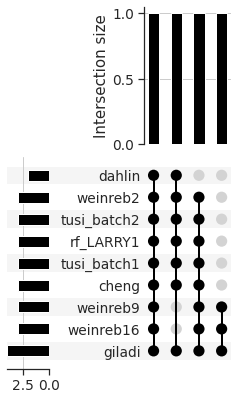

In [38]:
metaclusters = pymn.splitClusters(root_and_leaf, 4, save_uns=False)
metaclusters = dict(
    zip(['metacluster_' + str(i)
         for i in range(1,
                        len(metaclusters) + 1)], metaclusters))

root_and_leaf.uns['MetaNeighborUS_metaclusters'] = pd.Series(metaclusters)
root_and_leaf.uns['MetaNeighborUS_metaclusters_params'] = root_and_leaf.uns[
    'MetaNeighborUS_params']

pymn.plotUpset(root_and_leaf, mn_key='MetaNeighborUS_metaclusters')

In [39]:
mcs = metaclusters
mc_table = pd.Series(index=pd.MultiIndex.from_tuples(
    [
        tuple(a) for a in all_droplet.obs[['study_id', 'branch_name'
                                          ]].drop_duplicates().values.tolist()
    ],
    names=['Dataset', 'Cluster']),
                     name='Metacluster')
for mc, clusters in mcs.items():
    ds_clusts = [tuple(c.split('|')) for c in clusters]
    mc_table[ds_clusts] = mc

mc_table.to_csv(
    '/home/bharris/pseudotime/data/metacluster_dict_droplet_branches.csv')

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [41]:
root_and_leaf.obs['metacluster'] = mc_table[[
    tuple(a)
    for a in root_and_leaf.obs[['study_id', 'branch_name']].values.tolist()
]].values

### Intermediate MN

In [103]:
find_intermediates = np.vectorize(
    lambda x: len(re.findall(r'[Y]',
                             x.split('|')[1])) > 1)

intermediates = all_ps_adata.uns['MN_branch_complex'].index[find_intermediates(
    all_ps_adata.uns['MN_branch_complex'].index)]
intermediate_id = [x.split('|')[1] for x in intermediates]

intermediates_adata = all_ps_adata[all_ps_adata.obs.branch_name_complex.isin(
    intermediate_id)]

In [104]:
intermediates_adata.obs.study_id = intermediates_adata.obs.study_id.astype(str)
intermediates_adata.obs.branch_name_complex = intermediates_adata.obs.branch_name_complex.astype(
    str)

Trying to set attribute `.obs` of view, copying.


In [105]:
pymn.variableGenes(intermediates_adata, 'study_id')
print(intermediates_adata.var.highly_variable.sum())
pymn.MetaNeighborUS(intermediates_adata,
                    'study_id',
                    'branch_name_complex',
                    mn_key='MN_intermediates',
                    fast_version=True)

586


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/pymn/utils.py:179: RuntimeWarning: invalid value encountered in true_divide
  result /= n_neg[:, None]


In [106]:
pymn.MetaNeighborUS(intermediates_adata,
                    'study_id',
                    'branch_name_complex',
                    mn_key='MN_intermediates',
                    fast_version=True,
                    one_vs_best=True,
                    symmetric_output=False)

In [108]:
pymn.extractMetaClusters(intermediates_adata,
                         mn_key='MN_intermediates_1v1',
                         threshold=.7)
intermediates_adata.uns['MN_intermediates_1v1_metaclusters'].index = [
    'intermediate_' + i.split('_')[-1]
    for i in intermediates_adata.uns['MN_intermediates_1v1_metaclusters'].index
]
intermediates_adata.uns['MN_intermediates_1v1_metaclusters']

intermediate_1           [tusi_batch2|Y_95-Y_170, tusi_batch1|Y_1-Y_29-...
intermediate_2           [rf_LARRY1|Y_70-Y_291, tusi_batch1|Y_29-Y_51, ...
intermediate_outliers    [cheng|Y_5-Y_93, dahlin|Y_255-Y_264, dahlin|Y_...
dtype: object

In [112]:
mcs = intermediates_adata.uns['MN_intermediates_1v1_metaclusters'].to_dict()
inter_table = pd.Series(index=pd.MultiIndex.from_tuples(
    [
        tuple(a) for a in all_droplet.obs[['study_id', 'branch_name_complex'
                                          ]].drop_duplicates().values.tolist()
    ],
    names=['Dataset', 'Cluster']),
                        name='Metacluster')
for mc, clusters in mcs.items():
    ds_clusts = [tuple(c.split('|')) for c in clusters]
    inter_table[ds_clusts] = mc

inter_table.to_csv(
    '/home/bharris/pseudotime/data/metacluster_dict_droplet_intermediates.csv')

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


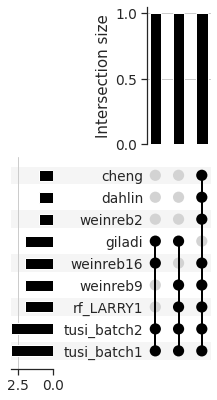

In [122]:
pymn.plotUpset(intermediates_adata,
               mn_key='MN_intermediates',
               metaclusters='MN_intermediates_1v1_metaclusters')

In [114]:
intermediates_adata.obs['metacluster'] = inter_table[[
    tuple(a) for a in intermediates_adata.obs[
        ['study_id', 'branch_name_complex']].values.tolist()
]].values

In [116]:
intermediates_adata.obs.metacluster.value_counts()

intermediate_outliers    45077
intermediate_1           28089
intermediate_2            3810
Name: metacluster, dtype: int64

In [117]:
combined_mc = concat([root_and_leaf, intermediates_adata])

In [118]:
df = pd.DataFrame(combined_mc.obsm['X_umap'],
                  columns=['UMAP1', 'UMAP2'],
                  index=combined_mc.obs_names)
dummies = pd.get_dummies(combined_mc.obs.metacluster)
dummies.columns = dummies.columns.astype(str)
df = pd.concat(
    [dummies, combined_mc.obs.study_id, df, combined_mc.obs.metacluster],
    axis=1)

### Select Erythroid and Monocyte Paths

In [302]:
exclude_branches = ['root']
leaf_mcs = ['metacluster_1','metacluster_2']
selected_leafs = (combined_mc.obs.groupby(['study_id','metacluster','branch_name']).
 size().
 to_frame(name='size').
 query('size > 0').
 reset_index().
 query('metacluster in @leaf_mcs').
 query('branch_name not in @exclude_branches'))

assignments = defaultdict(dict)
for key, branches in selected_leafs.groupby(['study_id','metacluster'])[['branch_name']].groups.items():
    selected_branches = []
    for branch in selected_leafs.loc[branches].branch_name.values:
        df = combined_mc.obs.query('study_id == @key[0]')
        selected_branches.extend(df[df.branch_name_complex.str.contains(branch)].branch_name_complex.unique())
    assignments[key[0]][key[1]] = selected_branches

for dataset, assign in assignments.items():
    mc_1_branch = assign['metacluster_1'] + ['root']
    mc_2_branch = assign['metacluster_2'] + ['root']
    
    mc_1_cell = combined_mc.obs.query('branch_name_complex in @mc_1_branch & study_id == @dataset').index
    mc_2_cell = combined_mc.obs.query('branch_name_complex in @mc_2_branch & study_id == @dataset').index
    
    shared_cells = np.intersect1d(mc_1_cell, mc_2_cell)

    mc_1_cell = mc_1_cell[~np.in1d(mc_1_cell, shared_cells)]
    mc_2_cell = mc_2_cell[~np.in1d(mc_2_cell, shared_cells)]

    shared_order = combined_mc.obs.loc[shared_cells,'monocle_ps'].sort_values()
    
    mc_1_cell = np.concatenate([mc_1_cell, shared_order.index[::2]])
    mc_2_cell = np.concatenate([mc_2_cell, shared_order.index[1::2]])
    
    combined_mc.obs.loc[mc_1_cell,'new_lineage'] = 'Erythroid'
    combined_mc.obs.loc[mc_2_cell,'new_lineage'] = 'Monocyte'

In [811]:
combined_mc_new_lineage = combined_mc[~combined_mc.obs.new_lineage.isna()]

combined_mc_new_lineage.obs['Study'] = [x[0].upper() + ''.join(re.findall(r'\d+',x)) for x in combined_mc_new_lineage.obs.study_id]

In [317]:
by_study_root_ranks = combined_mc[combined_mc.obs.metacluster ==
                                  'metacluster_3'].obs.groupby(
                                      'study_id')['monocle_ps'].rank()
tmp = combined_mc[combined_mc.obs.metacluster == 'metacluster_3'].obs[[
    'study_id', 'metacluster'
]]
tmp['root_rank'] = by_study_root_ranks

erythroid_root_cells = tmp.sort_values(['study_id',
                                        'root_rank']).iloc[::2].index

monocyte_root_cells = tmp.sort_values(['study_id',
                                       'root_rank']).iloc[1::2].index

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [318]:
erythroid_lineage_adata = concat([
    combined_mc[combined_mc.obs.metacluster.isin(
        ['metacluster_1', 'intermediate_1'])], combined_mc[erythroid_root_cells]
])



monocyte_lineage_adata = concat([
    combined_mc[combined_mc.obs.metacluster.isin(
        ['metacluster_2', 'intermediate_2'])], combined_mc[monocyte_root_cells]
])



erythroid_lineage_adata.obs['lineage'] = 'Erythroid'
monocyte_lineage_adata.obs['lineage'] = 'Monocyte'
combined_gapped_lineage = concat([erythroid_lineage_adata, monocyte_lineage_adata])



In [568]:
combined_mc_new_lineage.write_h5ad('/home/bharris/pseudotime/data/monocle/erythroid_and_monocyte_lineage_adata_no_gaps.h5ad')
combined_mc_new_lineage.write_loom('/home/bharris/pseudotime/data/monocle/erythroid_and_monocyte_lineage_adata_no_gaps.loom')

combined_mc_new_lineage[combined_mc_new_lineage.obs.new_lineage=='Erythroid'].write_h5ad(
    '/home/bharris/pseudotime/data/monocle/erythroid_lineage_adata_no_gaps.h5ad')
combined_mc_new_lineage[combined_mc_new_lineage.obs.new_lineage=='Erythroid'].write_loom(
    '/home/bharris/pseudotime/data/monocle/erythroid_lineage_adata_no_gaps.loom')


combined_mc_new_lineage[combined_mc_new_lineage.obs.new_lineage=='Monocyte'].write_h5ad(
    '/home/bharris/pseudotime/data/monocle/monocyte_lineage_adata_no_gaps.h5ad')
combined_mc_new_lineage[combined_mc_new_lineage.obs.new_lineage=='Monocyte'].write_loom(
    '/home/bharris/pseudotime/data/monocle/monocyte_lineage_adata_no_gaps.loom')


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'scNym' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'branch_name' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'branch_name_complex' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'metacluster' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'new_lineage' as categorical
The loom file will lack these fields:
{'X_scnym', 'X_umap'}
Use write_obsm_varm=True to export multi-dimensional annotations
The loom file will lack these fields:
{'X_scnym', 'X_umap'}
Use write_obsm_varm=True to export multi-dimensional annotations
The loom file will lack these fields:
{'X_scnym', 'X_umap'}
Use write_obsm_v

In [840]:
dataset_name_dict =  pd.Series([x[0].upper() + ''.join(re.findall(r'\d+',x)) for x in all_droplet.obs.study_id.unique()],
                               index=all_droplet.obs.study_id.unique())


/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/seaborn/matrix.py:1215: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


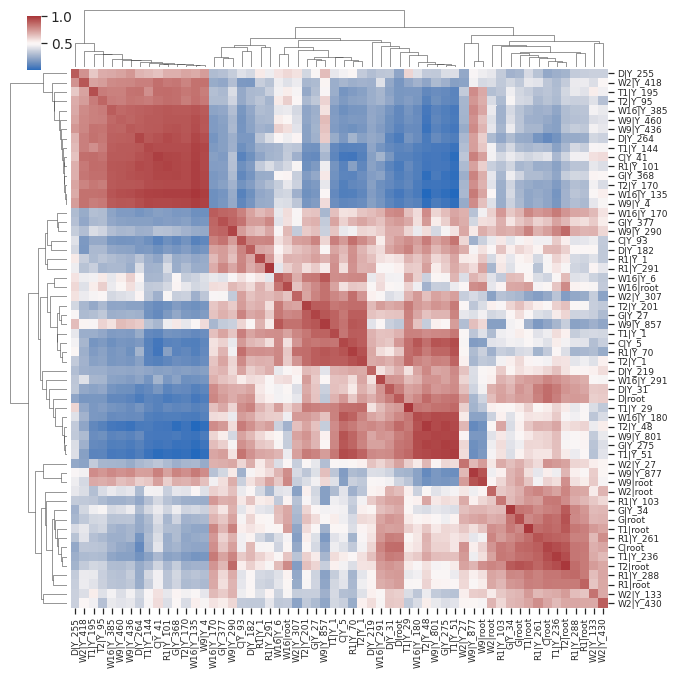

In [869]:
df = root_and_leaf.uns['MetaNeighborUS'].copy()
rename_axis = [f'{dataset_name_dict[val[0]]}|{val[1]}'for val in df.index.str.split('|')]
df.index = rename_axis
df.columns = rename_axis
g = pymn.plotMetaNeighborUS(df,
                            figsize=(10,10),
                            show=False,
                            xticklabels=True,
                            yticklabels=True,
                            cbar_pos=(.05,.89,.02,.075),
                            dendrogram_ratio=.1,
                            fontsize=9,
                            cmap='vlag')
g.savefig('/home/bharris/pseudotime/figures/supplements/pseudotime_root_mn.pdf',transparent=True)

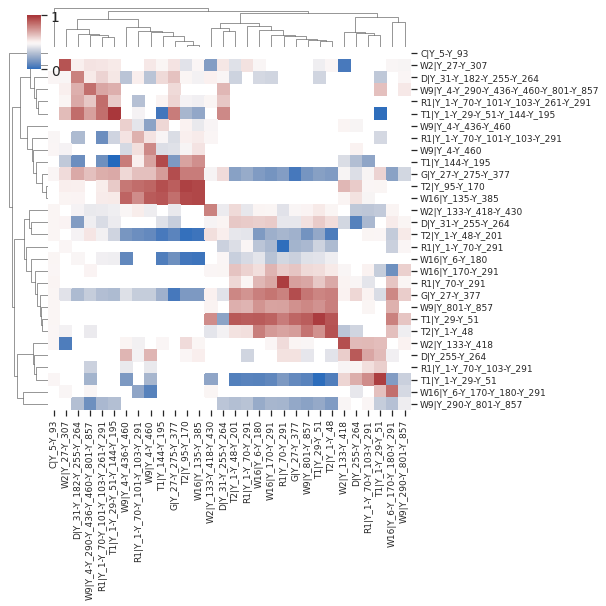

In [870]:
df = intermediates_adata.uns['MN_intermediates_1v1'].copy()
rename_axis = [f'{dataset_name_dict[val[0]]}|{val[1]}'for val in df.index.str.split('|')]
df.index = rename_axis
df.columns = rename_axis
g = pymn.plotMetaNeighborUS(df,
                            figsize=(10,10),
                            show=False,
                            xticklabels=True,
                            yticklabels=True,
                            cbar_pos=(.05,.89,.02,.075),
                            dendrogram_ratio=.1,
                            fontsize=9,
                            cmap='vlag')
g.savefig('/home/bharris/pseudotime/figures/supplements/pseudotime_intermediates_mn.pdf',transparent=True)

In [390]:
mc_assign = pd.concat([root_and_leaf.uns['MetaNeighborUS_metaclusters'],
                       intermediates_adata.uns['MN_intermediates_1v1_metaclusters']])

all_mc_table = pd.Series(index=pd.MultiIndex.from_tuples(
    [
        tuple(a) for a in all_ps_adata.obs[['study_id', 'branch_name_complex'
                                          ]].drop_duplicates().values.tolist()
    ],
    names=['Dataset', 'Cluster']),
                     name='Metacluster')
for mc, clusters in mc_assign.items():
    ds_clusts = [tuple(c.split('|')) for c in clusters]
    all_mc_table[ds_clusts] = mc

/home/bharris/miniconda3/envs/python3_base/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


### Plot MST MetaNeighbor Results

In [816]:
all_droplet.obs['Study'] =  [x[0].upper() + ''.join(re.findall(r'\d+',x)) for x in all_droplet.obs.study_id]

col_order = np.unique(all_droplet.obs.Study)

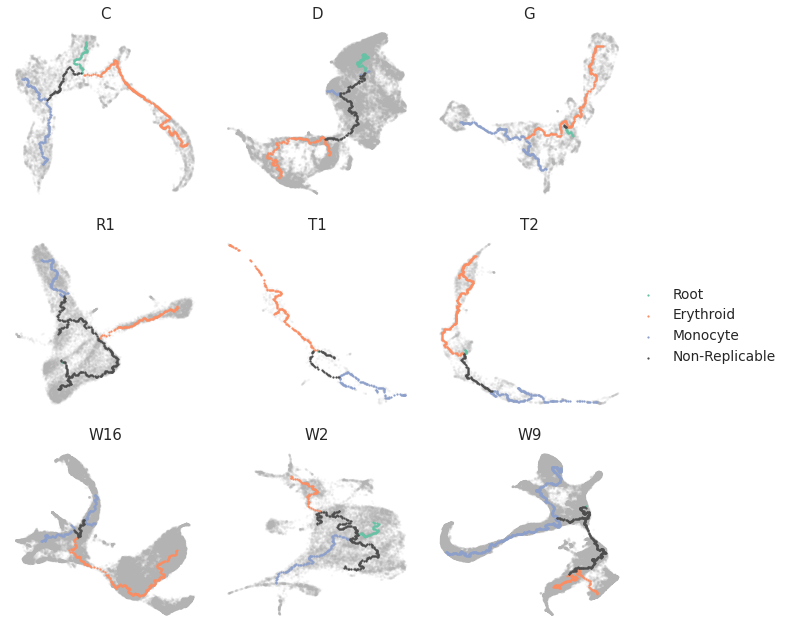

In [826]:
all_vertex_info = []
all_dataset_adj = {}
for dataset in all_ps_adata.obs.study_id.unique():
    adj = pd.read_csv(f'~/pseudotime/data/monocle/mst_adjacency_{dataset}.csv',
                      index_col=0)
    vertex_info = pd.read_csv(f'/home/bharris/pseudotime/data/monocle/mst_vertex_info_{dataset}.csv',
                              index_col=0)
    tmp=all_ps_adata.obs[['study_id','branch_name_complex','scNym','monocle_ps']].query('study_id == @dataset')
    tmp['metacluster'] = all_mc_table.loc[dataset][tmp.branch_name_complex].values
    vertex_info = pd.concat([tmp,vertex_info],axis=1).dropna(subset=['study_id'])
    
    all_vertex_info.append(vertex_info)
    all_dataset_adj[dataset] = adj

all_vertex_info = pd.concat(all_vertex_info)
all_vertex_info.loc[all_vertex_info.branch_name_complex=='root','metacluster'] = 'Root'
all_vertex_info.loc[all_vertex_info.metacluster.isin(['intermediate_outliers','metacluster_4','metacluster_3']),'metacluster'] = 'Non-Replicable'
all_vertex_info.loc[all_vertex_info.metacluster.isin(['metacluster_1','intermediate_1']),'metacluster'] = 'Erythroid'
all_vertex_info.loc[all_vertex_info.metacluster.isin(['metacluster_2','intermediate_2']),'metacluster'] = 'Monocyte'
all_vertex_info['Study'] =  [x[0].upper() + ''.join(re.findall(r'\d+',x)) for x in all_vertex_info.study_id]
pal= sns.color_palette('Set2',4)

pal[3] = '.3'

g = sns.FacetGrid(data=(all_vertex_info
                        .drop_duplicates(subset=['nearest_vertex','Study'])
                        .sort_values(['metacluster','monocle_ps'])
                        .rename(columns={'metacluster':' '})),
                col='Study',
                hue=' ', 
                hue_order=['Root','Erythroid','Monocyte','Non-Replicable'],
                palette=pal,
                legend_out=True,
                sharex=False,
                sharey=False,
                col_order=col_order,
                col_wrap=3)
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
    sns.scatterplot(data=all_ps_adata.obs.loc[all_vertex_info.query('Study==@study').index],
                x='monocle_UMAP1',
                y='monocle_UMAP2',
                color='.7',
                ax=ax,
                alpha=.1,
                legend=False,
                rasterized=True,
                edgecolor='none',
                s=5)
g.map_dataframe(sns.scatterplot, 
                x='UMAP1',
                y='UMAP2',
                s=5,
                edgecolor=None, 
                linewidth=0)
g.set_titles('{col_name}')
g.add_legend()

g.savefig('/home/bharris/pseudotime/figures/pseudotime_gene_signatures/pseudotime_mst.pdf',
          transparent=True)

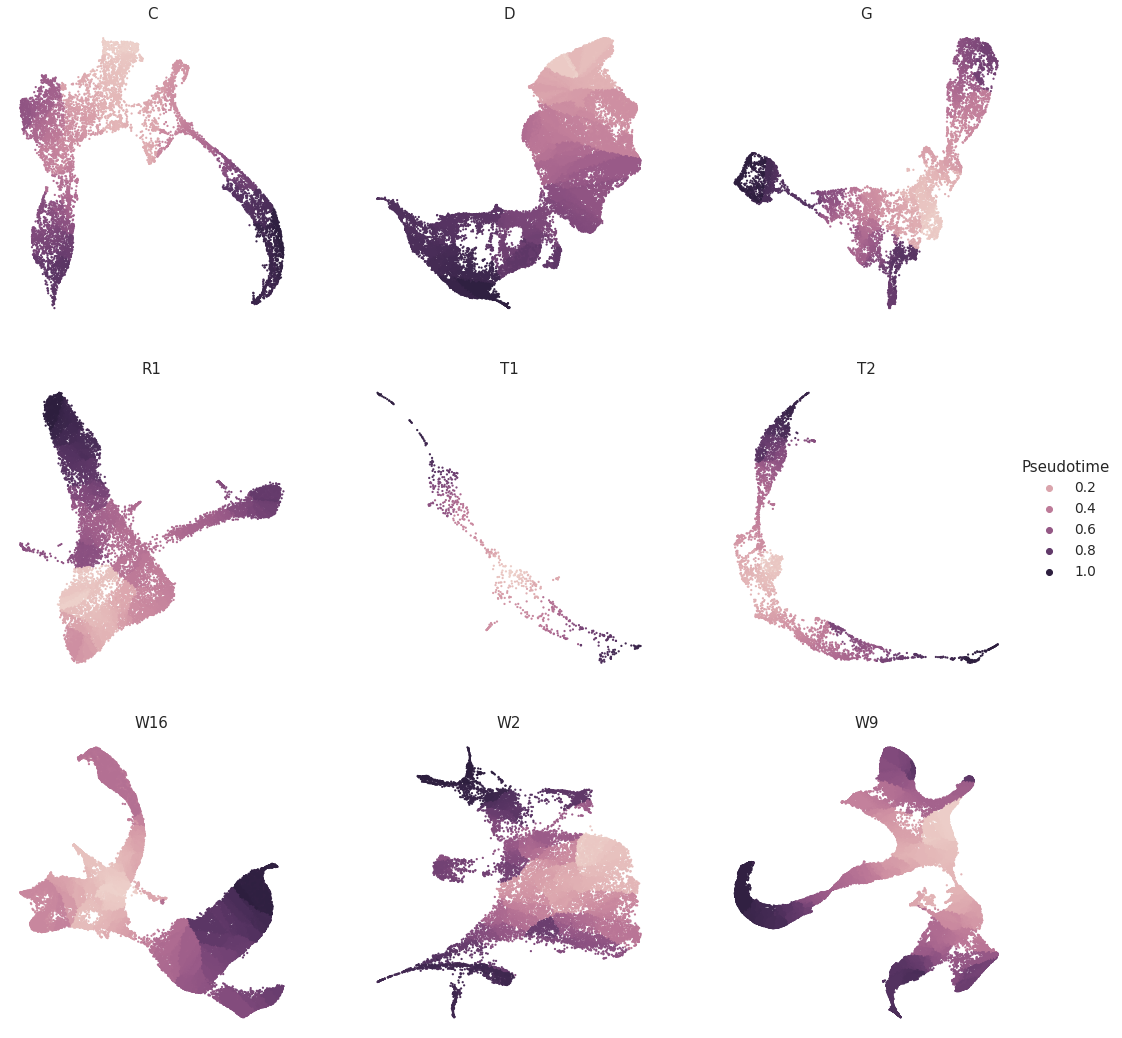

In [820]:
g = sns.relplot(data=all_ps_adata.obs.rename(columns={'monocle_ps':'Pseudotime'}),
                col='Study',
                hue='Pseudotime', 
                x='monocle_UMAP1',
                y='monocle_UMAP2',
                s=5,
                edgecolor='none',
                linewidth=0,
                facet_kws={'sharex':False,
                           'sharey':False},
                rasterized=True,
                col_order=col_order,
                col_wrap=3)
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')
g.savefig('/home/bharris/pseudotime/figures/pseudotime_gene_signatures/pseudotime_umap_pseudotime_color.pdf',
          transparent=True)

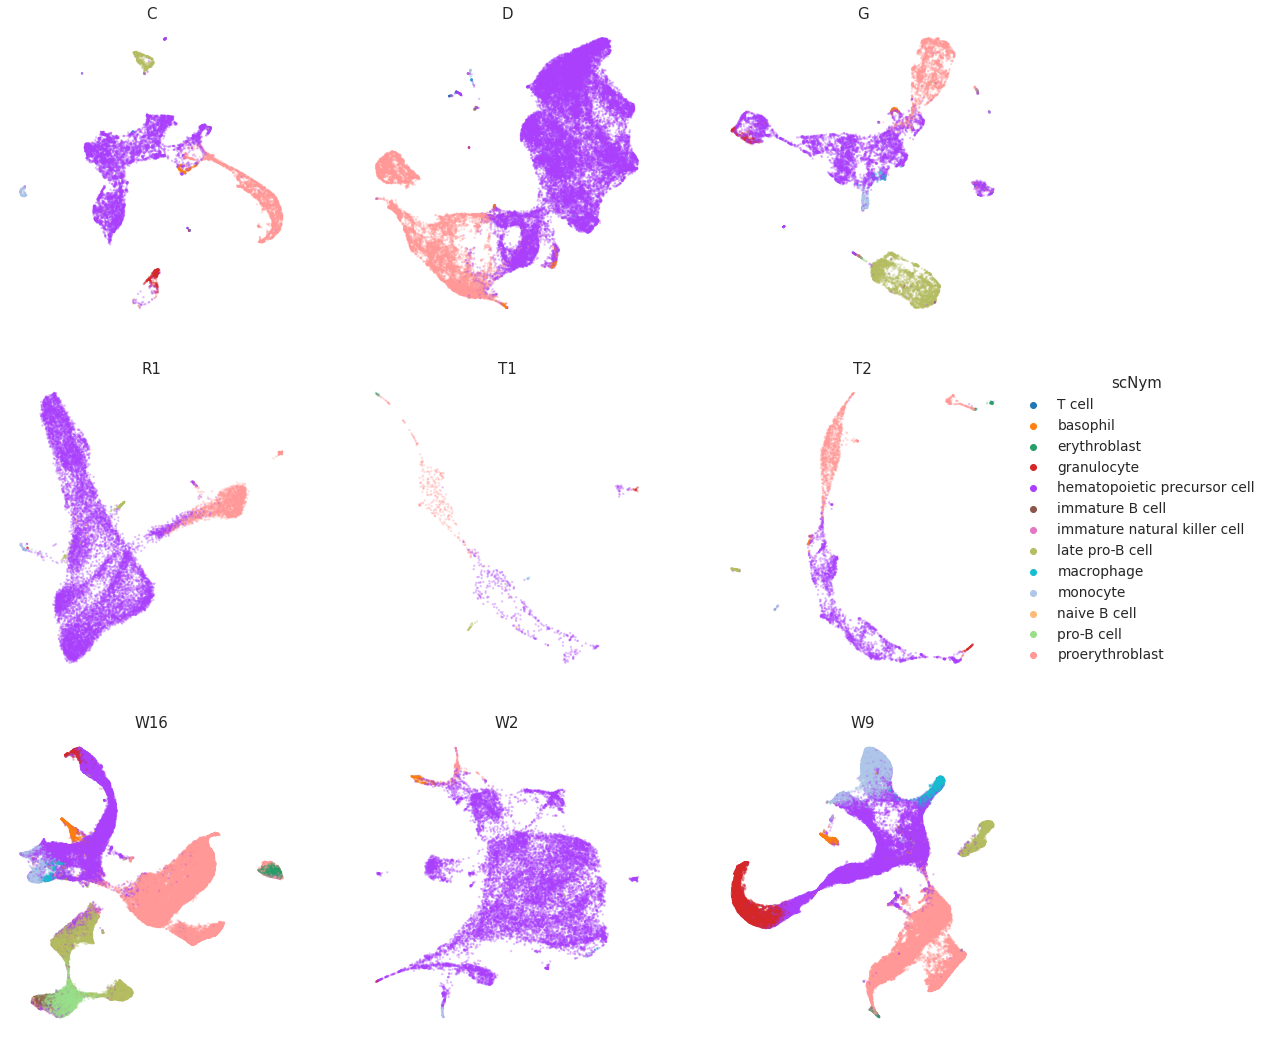

In [824]:
ct_pal = (pd.read_csv('/home/bharris/pseudotime/data/tabula_muris_cell_type_pal.csv',index_col=0)['0']
          .apply(lambda  x : tuple([float(i) for i in x[1:-1].split(',')])))
ct_pal = ct_pal.to_dict()

g = sns.relplot(data=all_droplet.obs.rename(columns={'monocle_ps':'Pseudotime'}),
                col='Study',
                hue='scNym', 
                alpha=.35,
                x='monocle_UMAP1',
                y='monocle_UMAP2',
                s=5,
                edgecolor='none',
                palette=ct_pal,
                col_order=col_order,
                linewidth=0,
                facet_kws={'sharex':False,
                           'sharey':False},
                rasterized=True,
                col_wrap=3)
g.set_titles('{col_name}')
for ax, study in zip(g.fig.axes, g.col_names):
    ax.axis('off')

plt.savefig('/home/bharris/pseudotime/figures/pseudotime_gene_signatures/unfiltered_scNym_umaps.pdf',
            transparent=True)

In [ ]:
# erythroid_lineage_adata.write_h5ad(
#     '/home/bharris/pseudotime/data/monocle/erythroid_lineage_adata.h5ad')
# erythroid_lineage_adata.write_loom(
#     '/home/bharris/pseudotime/data/monocle/erythroid_lineage_adata.loom')

# monocyte_lineage_adata.write_h5ad(
#     '/home/bharris/pseudotime/data/monocle/monocyte_lineage_adata.h5ad')
# monocyte_lineage_adata.write_loom(
#     '/home/bharris/pseudotime/data/monocle/monocyte_lineage_adata.loom')

# combined_gapped_lineage.write_h5ad(
#     '/home/bharris/pseudotime/data/monocle/erythroid_and_monocyte_lineage_adata.h5ad'
# )
# concat([erythroid_lineage_adata, monocyte_lineage_adata]).write_loom(
#     '/home/bharris/pseudotime/data/monocle/erythroid_and_monocyte_lineage_adata.loom'
# )add_legendto_dict